In [ ]:
#@title Mount google drive and git pull
# this cell is to load the google drive to the directory
from google.colab import drive
drive.mount('/content/drive')

""" If it is the first time to set up the directory
%cd /content/drive/My\ Drive/Hpython/

!git clone https://github.com/chenhao1umbc/WSCDL.git
%cd WSCDL/
print('')
!ls
"""

# setting up the working directory
print('current folder is ')
%cd /content/drive/My\ Drive/Hpython/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
current folder is 
/content/drive/My Drive/Hpython


---
# Running experiments in the following section
---



In [ ]:
import os
import pandas as pd
import scipy.io as sio
import h5py 
import numpy as np

import torch
from torch import nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt

"make the result reproducible"
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

folder = '/content/drive/My Drive/Hpython/data/q16005n2/'
fname1 = 'norm_db449_6classq16&0.05n2_positive_M2_snr2000.mat'
fname2 = 'norm_db449_6classq16&0.05n2_negative_M2_snr2000.mat'
a1 = h5py.File(folder + fname1, 'r')
a2 = h5py.File(folder + fname2, 'r')
d1 = torch.tensor(a1['db']['features'][()]).float()
d2 = torch.tensor(a2['db2']['features'][()]).float()
x = torch.stack([d1, d2], dim= 1).unsqueeze(1)
n = x.shape[0]  # number of samples

"adding labels"
# "For cross-entropy loss"
# y = torch.zeros(n).long()
# for i in range(6):
#     y[int(n/6)*i: int(n/6)*(i+1)] = i

"For MSE loss with one hot encoding"
y = torch.zeros(n, 6)
for i in range(6):
    temp = torch.zeros(6)
    temp[i] = 1.0
    y[int(n/6)*i: int(n/6)*(i+1)] = temp

In [ ]:
#@title split data to test and train/validate
def expand_index(idx0):
    idx = []
    for i in range(8):
        idx = idx + ([ii*8+i for ii in idx0])
    idx.sort()
    idx0 = idx.copy()
    for i in range(1,6):
        idx = idx + [i*449*8 + ii for ii in idx0]
    return idx

def aoos(x):
    """average over one sample"""
    xx = torch.zeros((int(x.shape[0]/8),) + x.shape[1:])
    for i in range(xx.shape[0]):
        xx[i] = x[i*8:(i+1)*8].mean(0)
    return xx

"test index from matlab"
ii = '307	414	173	36	385	318	116	82	323	71	215	444	23	141	370	288	126	137	430	207	392	363	262	293	65	277	158	153	276	285	225	2	391	132	263	114	4	18	85	342	222	245	75	191	24	95	206	167	348	432	154	39	341	168	13	9	434	66	20	57	122	251	10	416	12	313	297	226	368	386	350	334	260	118	359'
a = ii[1:275].split('\t')
test_idx = expand_index([int(i) for i in a])
tv_idx = np.delete(np.arange(n), test_idx)
x_test, y_test = x[test_idx], y[test_idx]
data0 = Data.TensorDataset(x_test, y_test)
test_data = Data.DataLoader(data0, batch_size=1024, shuffle=False)

np.random.seed(0)
trcvd = x[tv_idx].numpy()
np.random.shuffle(trcvd)
np.random.seed(0)
trcdl = y[tv_idx].numpy()
np.random.shuffle(trcdl)

tr_d, tr_l =torch.tensor(trcvd[:2400*6]), torch.tensor(trcdl[:2400*6])
cv_d, cv_l =torch.tensor(trcvd[2400*6:]), torch.tensor(trcdl[2400*6:])

data2 = Data.TensorDataset(tr_d,tr_l)
train_data = Data.DataLoader(data2, batch_size=1024, shuffle=True)

data1 = Data.TensorDataset(cv_d,cv_l)
cv_data = Data.DataLoader(data1, batch_size=1024, shuffle=False)


In [ ]:
#@title Model

class Model(nn.Module):
    def __init__(self, opt):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
                    nn.Conv2d(1, 256, kernel_size=(1,3), padding=(0, 1)),  # Channels_in, Chnannels_out, Kernal_size
                    nn.Dropout(opt['drop_rate']),
                    nn.ReLU(True))  # inplace=True, means save GPU memory, but covering old value

        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 80, kernel_size=(2,3), padding=(0, 1)),  # Channels_in, Chnannels_out, Kernal_size
            nn.Dropout(opt['drop_rate']),
            nn.ReLU(True))  # inplace=True, means save GPU memory, but covering old value    

        self.FC1 = nn.Sequential(
            nn.Linear(80*557, 256),  # Channels_in, Chnannels_out, Kernal_size
            nn.ReLU(True))  # inplace=True, means save GPU memory, but covering old value 

        self.FC2 = nn.Sequential(
            nn.Linear(256, 6),  # Channels_in, Chnannels_out, Kernal_size
            nn.Softmax(dim=1))  # inplace=True, means save GPU memory, but covering old value 

    def forward(self, x):
        # FC_encoder
        x = self.conv1(x)  # input x is (N,C,L)
        x = self.conv2(x)
        emb = self.FC1(x.reshape(x.shape[0], -1))
        x = self.FC2(emb)

        return x, emb

In [ ]:
#@title Training
opt = {}
opt['n_epochs'] = 101
opt['lr'] = 0.0001
opt['drop_rate'] = 0.4

model = Model(opt).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=opt['lr'], weight_decay=1e-5)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()  # with one hot encoding

loss_train = []
loss_cv = []
for epoch in range(opt['n_epochs']):
    for data, y in train_data: 
        model.train()    
        x = data.cuda()
        yh, emb = model(x)
        
        optimizer.zero_grad()  
        loss = criterion(yh, y.cuda())              
        loss.backward()
        optimizer.step()
        loss_train.append(loss.data.item())

    model.eval()
    with torch.no_grad():
        cv_yh = torch.rand(cv_d.shape[0], 6)
        for i, cvd in enumerate(cv_d):
            cv_cuda = cvd[None, :, :, :].cuda()
            cv_yh[i] = model(cv_cuda)[0].cpu()
        cv_loss = Func.mse_loss(cv_yh,cv_l)
        loss_cv.append(cv_loss)
    torch.cuda.empty_cache()
    if epoch%20 ==0:
        plt.figure()
        plt.plot(loss_train, '-x')
        plt.figure()
        plt.plot(loss_cv, '--xr')
        plt.show()

    if epoch>60:
        torch.save(model.state_dict(), './saved_models/drop_04_CNN'+str(epoch)+'.pt')

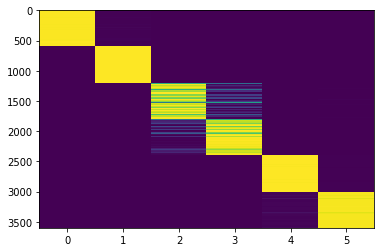

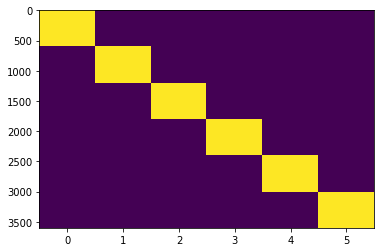

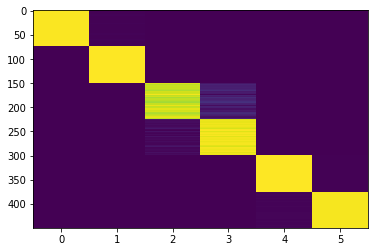

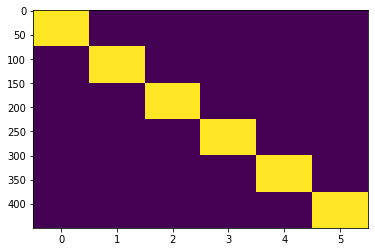

In [ ]:
#@title Test pure


opt = {}
opt['n_epochs'] = 100
opt['lr'] = 0.0001
opt['drop_rate'] = 0.6

model = Model(opt).cuda()
model.load_state_dict(torch.load('./saved_models/drop_04_CNN95.pt'))
model.eval()
with torch.no_grad():
    test_label = torch.rand(len(test_idx), 6)
    for i, (x_te, _) in enumerate(data0):
        x_cuda = x_te[None, :, :, :].cuda()
        test_label[i] = model(x_cuda)[0].cpu()
plt.imshow(test_label, aspect='auto', interpolation='None')
plt.figure()
plt.imshow(y_test, aspect='auto', interpolation='None')


xx = aoos(x_test)
with torch.no_grad():
    test_label = torch.rand(xx.shape[0], 6)
    for i, xx0 in enumerate(xx):
        x_cuda = xx0[None, :, :, :].cuda()
        test_label[i] = model(x_cuda)[0].cpu()
plt.figure()
plt.imshow(test_label, aspect='auto', interpolation='None')
plt.figure()
plt.imshow(aoos(y_test), aspect='auto', interpolation='None')

In [ ]:
#@title Test mixture


import os
import pandas as pd
import scipy.io as sio
import h5py 
import numpy as np

import torch
from torch import nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt

"make the result reproducible"
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

folder = '/content/drive/My Drive/Hpython/data/q16005n2/'
fname1 = 'L2_0db.mat'   # everytime change the test file 
a = sio.loadmat(folder + fname1)
temp = torch.tensor(a['Y'])
td = torch.zeros(2, 557, temp.shape[-1])
td[0] = temp[:557]
td[1] = temp[557:].flip(0)
dd = (td.reshape(2*557, temp.shape[-1]).t()).reshape(temp.shape[-1], 2, 557)
x_mix = dd.unsqueeze(1)


opt = {}
opt['n_epochs'] = 100
opt['lr'] = 0.0001
opt['drop_rate'] = 0.6

model = Model(opt).cuda()
model.load_state_dict(torch.load('./saved_models/drop_04_CNN95.pt'))
model.eval()
xx = aoos(x_mix)
with torch.no_grad():
    test_label = torch.rand(xx.shape[0], 6)
    for i, xx0 in enumerate(xx):
        x_cuda = xx0[None, :, :, :].cuda()
        test_label[i] = model(x_cuda)[0].cpu()

res = {'tl':test_label.numpy()}
sio.savemat('L2_0db_test_ressult.mat', res)  # change the filename

In [ ]:
sio.loadmat('L2_0db_test_ressult.mat')

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Aug  8 00:23:25 2020',
 '__version__': '1.0',
 'tl': array([[2.8213512e-03, 9.9717867e-01, 2.1225434e-10, 3.3824594e-14,
         1.6127934e-15, 8.6707724e-10],
        [2.5976547e-03, 9.9740237e-01, 1.7659667e-10, 2.8810650e-14,
         1.4776289e-15, 7.7411633e-10],
        [2.4480589e-03, 9.9755198e-01, 1.7701436e-10, 2.8098444e-14,
         1.5004763e-15, 7.6355033e-10],
        ...,
        [5.8604899e-10, 7.7993798e-09, 6.7610619e-09, 3.1641363e-12,
         9.9723464e-01, 2.7653619e-03],
        [5.8634930e-10, 7.8357250e-09, 6.6700503e-09, 3.1464820e-12,
         9.9724329e-01, 2.7566755e-03],
        [6.0899391e-10, 7.9406002e-09, 6.9863626e-09, 3.3914852e-12,
         9.9713802e-01, 2.8619557e-03]], dtype=float32)}

# Using cross-entropy to train the network

In [ ]:
import os
import pandas as pd
import scipy.io as sio
import h5py 
import numpy as np

import torch
from torch import nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt

"make the result reproducible"
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

folder = '/content/drive/My Drive/Hpython/data/q16005n2/'
fname1 = 'norm_db449_6classq16&0.05n2_positive_M2_snr2000.mat'
fname2 = 'norm_db449_6classq16&0.05n2_negative_M2_snr2000.mat'
a1 = h5py.File(folder + fname1, 'r')
a2 = h5py.File(folder + fname2, 'r')
d1 = torch.tensor(a1['db']['features'][()]).float()
d2 = torch.tensor(a2['db2']['features'][()]).float()
x = torch.stack([d1, d2], dim= 1).unsqueeze(1)
n = x.shape[0]  # number of samples

"adding labels"
"For cross-entropy loss"
y = torch.zeros(n).long()
for i in range(6):
    y[int(n/6)*i: int(n/6)*(i+1)] = i

# "For MSE loss with one hot encoding"
# y = torch.zeros(n, 6)
# for i in range(6):
#     temp = torch.zeros(6)
#     temp[i] = 1.0
#     y[int(n/6)*i: int(n/6)*(i+1)] = temp

In [ ]:
#@title split data to test and train/validate
def expand_index(idx0):
    idx = []
    for i in range(8):
        idx = idx + ([ii*8+i for ii in idx0])
    idx.sort()
    return idx

"test index from matlab"
ii = '307	414	173	36	385	318	116	82	323	71	215	444	23	141	370	288	126	137	430	207	392	363	262	293	65	277	158	153	276	285	225	2	391	132	263	114	4	18	85	342	222	245	75	191	24	95	206	167	348	432	154	39	341	168	13	9	434	66	20	57	122	251	10	416	12	313	297	226	368	386	350	334	260	118	359'
a = ii[1:275].split('\t')
test_idx = expand_index([int(i) for i in a])
tv_idx = np.delete(np.arange(n), test_idx)

data0 = Data.TensorDataset(x[test_idx], y[test_idx])
test_data = Data.DataLoader(data0, batch_size=1024, shuffle=False)

np.random.seed(0)
trcvd = x[tv_idx].numpy()
np.random.shuffle(trcvd)
np.random.seed(0)
trcdl = y[tv_idx].numpy()
np.random.shuffle(trcdl)

tr_d, tr_l =torch.tensor(trcvd[:2400*6]), torch.tensor(trcdl[:2400*6])
cv_d, cv_l =torch.tensor(trcvd[2400*6:]), torch.tensor(trcdl[2400*6:])

data0 = Data.TensorDataset(tr_d,tr_l)
train_data = Data.DataLoader(data0, batch_size=1024, shuffle=True)

data1 = Data.TensorDataset(cv_d,cv_l)
cv_data = Data.DataLoader(data1, batch_size=1024, shuffle=False)


In [ ]:
#@title Model

class Model(nn.Module):
    def __init__(self, opt):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
                    nn.Conv2d(1, 256, kernel_size=(1,3), padding=(0, 1)),  # Channels_in, Chnannels_out, Kernal_size
                    nn.Dropout(opt['drop_rate']),
                    nn.ReLU(True))  # inplace=True, means save GPU memory, but covering old value

        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 80, kernel_size=(2,3), padding=(0, 1)),  # Channels_in, Chnannels_out, Kernal_size
            nn.Dropout(opt['drop_rate']),
            nn.ReLU(True))  # inplace=True, means save GPU memory, but covering old value    

        self.FC1 = nn.Sequential(
            nn.Linear(80*557, 256),  # Channels_in, Chnannels_out, Kernal_size
            nn.ReLU(True))  # inplace=True, means save GPU memory, but covering old value 

        self.FC2 = nn.Sequential(
            nn.Linear(256, 6),  # Channels_in, Chnannels_out, Kernal_size
            nn.Softmax(dim=1))  # inplace=True, means save GPU memory, but covering old value 

    def forward(self, x):
        # FC_encoder
        x = self.conv1(x)  # input x is (N,C,L)
        x = self.conv2(x)
        emb = self.FC1(x.reshape(x.shape[0], -1))
        x = self.FC2(emb)

        return x, emb

In [ ]:
opt = {}
opt['n_epochs'] = 100
opt['lr'] = 0.0001
opt['drop_rate'] = 0.6

model = Model(opt).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=opt['lr'], weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()  # with one hot encoding

loss_train = []
loss_cv = []
for epoch in range(opt['n_epochs']):
    for data, y in train_data: 
        model.train()    
        x = data.cuda()
        yh, emb = model(x)
        
        optimizer.zero_grad()  
        loss = criterion(yh, y.cuda())              
        loss.backward()
        optimizer.step()
        loss_train.append(loss.data.item())

    model.eval()
    with torch.no_grad():
        cv_yh = torch.rand(cv_d.shape[0], 6)
        for i, cvd in enumerate(cv_d):
            cv_cuda = cvd[None, :, :, :].cuda()
            cv_yh[i] = model(cv_cuda)[0].cpu()
        cv_loss = Func.cross_entropy(cv_yh,cv_l)
        loss_cv.append(cv_loss)
    torch.cuda.empty_cache()

    # print('epoch [{}/{}], loss:{:.8f}'
    #     .format(epoch + 1, opt['n_epochs'], loss.data.item()))
    plt.figure()
    plt.plot(loss_train, '-x')
    plt.figure()
    plt.plot(loss_cv, '--xr')
    plt.show()

    if epoch>10:
        torch.save(model.state_dict(), './CNN_cren_'+str(epoch)+'.pt')

In [ ]:
opt = {}
opt['n_epochs'] = 100
opt['lr'] = 0.0001
opt['drop_rate'] = 0.6

model = Model(opt).cuda()
model.load_state_dict(torch.load('./CNN_cren_78.pt'))
model.eval()
with torch.no_grad():
    cv_yh = torch.rand(cv_d.shape[0], 6)
    for i, cvd in enumerate(cv_d):
        cv_cuda = cvd[None, :, :, :].cuda()
        cv_yh[i] = model(cv_cuda)[0].cpu()
    cv_loss = Func.cross_entropy(cv_yh,cv_l)
    loss_cv.append(cv_loss)
torch.cuda.empty_cache()
plt.imshow(cv_yh, aspect='auto', interpolation='None')



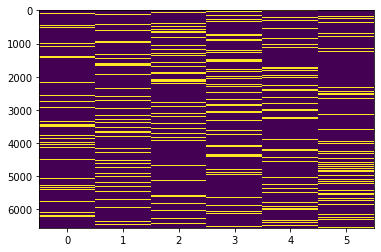

In [ ]:
plt.figure()
plt.imshow(cv_l, aspect='auto', interpolation='None')